### Importing all the libraries

In [18]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from transformers import pipeline, AutoTokenizer, AutoConfig
from tqdm import tqdm

# This is being imported to remove stop words in the responses
nltk.download('stopwords', quiet = True)
stop_words = set(stopwords.words('english'))


### Importing and Pre-Processing Text

In [19]:
# Load the survey data
file_path = r"PATH_TO_YOUR_CSV_FILE"
survey_data = pd.read_csv(file_path)

# Extract relevant columns and combine responses into a single text column
survey_data_combined = survey_data.iloc[1:].copy()
survey_data_combined.columns = survey_data.iloc[0]
survey_data_combined.reset_index(drop=True, inplace=True)

# Extract all responses
responses = survey_data_combined.filter(like='response').fillna('').values.flatten()
responses = [response for response in responses if response != '']

### Load the Sentence Transformer model to create Embeddings for each response

In [20]:
# Calculate sentence embeddings using a pre-trained model

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(responses)

# Create a distance matrix using cosine similarity
distance_matrix = cosine_similarity(embeddings)

## Clusterterization of the Embeddings

- This steps is done to clusterize te the responses based on their similarity.
- Responses falling in the same cluster would have similar meanings and could be referring to similar topics

### Finding the Optimal number of Clusters using Silhouette Score and Elbow Plot

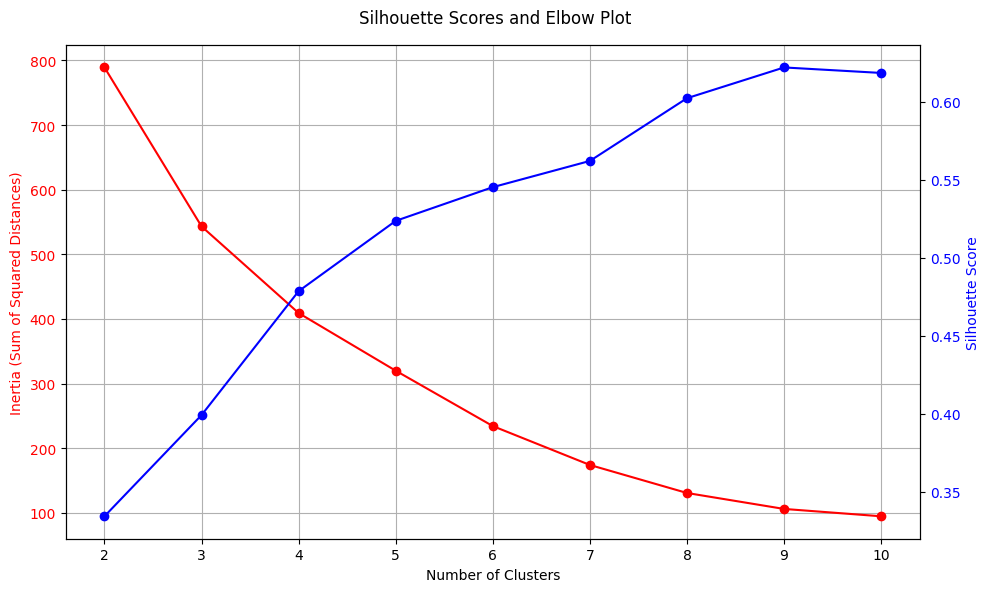

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

range_n_clusters = range(2, 11)

silhouette_scores = []
inertia = []

for n_clusters in range_n_clusters:
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    hc_clusters = hc.fit_predict(distance_matrix)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(distance_matrix, hc_clusters)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate Inertia (Sum of Squared Distances)
    centroids = np.array([distance_matrix[hc_clusters == i].mean(axis=0) for i in range(n_clusters)])
    cluster_inertia = sum(np.sum((distance_matrix[hc_clusters == i] - centroids[i])**2) for i in range(n_clusters))
    inertia.append(cluster_inertia)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Inertia (Sum of Squared Distances)
ax1.plot(range_n_clusters, inertia, marker='o', color='red', label='Inertia (Sum of Squared Distances)')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia (Sum of Squared Distances)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary y-axis for Silhouette Scores
ax2 = ax1.twinx()
ax2.plot(range_n_clusters, silhouette_scores, marker='o', color='blue', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a title and show the plot
fig.suptitle('Silhouette Scores and Elbow Plot')
ax1.set_xticks(range_n_clusters)
ax1.grid(True)

fig.tight_layout()
plt.show()

### Fitting the Clusters back to the Dataframe

In [22]:
optimal_clusters = 4
hc = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
hc_clusters = hc.fit_predict(distance_matrix)

# Create a dataframe with the results
clustered_responses_df = pd.DataFrame({'Response': responses, 'Cluster': hc_clusters})
clustered_responses_df.head()

,Response,Cluster
0,The construction timeline for the M6 junction ...,2
1,Transparent cost management is crucial for the...,0
2,The engineering design should prioritize long-...,2
3,The environmental impact of the project is a s...,2
4,Resolving land ownership issues fairly and tra...,0


### Cluster Visualization

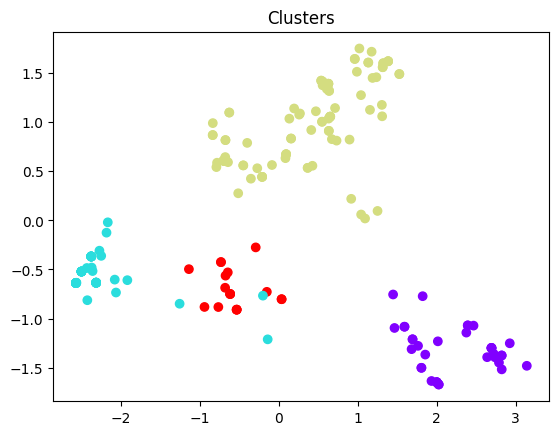

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(distance_matrix)

# Plot Agglomerative clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=hc_clusters, cmap='rainbow')
plt.title('Clusters')
plt.show()


## Identifying the Topics (LDA) and Sentiments (Sentiment Analysis) in each Cluster

### Creating the Corpus and Dictionary from the Responses

This step is required to create the LDA model that finds the topics in each cluster

In [24]:
# Define a function to preprocess the text
def preprocess(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Preprocess the responses
processed_texts = [preprocess(response) for response in responses]
tokenized_articles = [text.split() for text in processed_texts]

# Create Dictionary and Corpus
id2word = corpora.Dictionary(tokenized_articles)
corpus = [id2word.doc2bow(text) for text in tokenized_articles]

### Identify best parameters for LDA

In [25]:
# Function to calculate coherence score
def calculate_coherence_score(n, alpha, beta):
    lda_model = LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha=alpha,
                                                per_word_topics=True,
                                                eta=beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# List containing various hyperparameters
no_of_topics = [2, 5, 7, 10]
alpha_list = ['symmetric', 0.3, 0.5, 0.7]
beta_list = ['auto', 0.3, 0.5, 0.7]

# Evaluate coherence scores for different hyperparameters
best_coherence = 0
best_params = (0, 0, 0)

for n in tqdm(no_of_topics, desc = "Calculating Best Parameters: "):
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            # print(f"n: {n}, alpha: {alpha}, beta: {beta}, Score: {coherence_score}") # Remove this part if you want the script to print the coherence score for each parameter
            if coherence_score > best_coherence:
                best_coherence = coherence_score
                best_params = (n, alpha, beta)
                
optimal_num, optimal_alpha, optimal_beta = best_params

print(f"\nBest coherence score: {best_coherence} with parameters: no_of_topics={optimal_num}, alpha={optimal_alpha}, beta={optimal_beta}")


Calculating Best Parameters: 100%|██████████| 4/4 [03:47<00:00, 56.78s/it]


Best coherence score: 0.6941937414166554 with parameters: no_of_topics=10, alpha=symmetric, beta=0.5


### Function to apply LDA

In [26]:
def apply_lda_to_cluster(responses, num_topics=optimal_num, alpha=optimal_alpha, beta=optimal_beta):
    processed_texts = [preprocess(response) for response in responses]
    texts_split = [text.split() for text in processed_texts]
    dictionary = corpora.Dictionary(texts_split)
    corpus = [dictionary.doc2bow(text) for text in texts_split]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1000, alpha=alpha, eta=beta, per_word_topics=True)
    topics = lda.print_topics()
    clean_topics = set()
    for topic in topics:
        words = re.findall(r'"(.*?)"', topic[1])
        clean_topics.add(', '.join(words))
    return list(clean_topics)

### To Filter only Topics with Negative Sentiments

In [27]:
# Initialize sentiment analysis pipeline with a specific model
model = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=AutoTokenizer.from_pretrained(model), config=AutoConfig.from_pretrained(model))

# Perform sentiment analysis and topic modeling
for cluster_number in range(optimal_clusters):
    cluster_responses = clustered_responses_df[clustered_responses_df['Cluster'] == cluster_number]['Response'].tolist()
    
    # This is the part that identifies the sentiments inside the responses
    sentiments = sentiment_pipeline(cluster_responses)
    
    sentiment_df = pd.DataFrame(sentiments)
    cluster_sentiment_df = pd.concat([pd.Series(cluster_responses, name='Response'), sentiment_df], axis=1)
    
    # Filtering only the items that were tagged as negative by the model
    negative_sentiments = cluster_sentiment_df[cluster_sentiment_df['label'] == 'negative']
    
    if not negative_sentiments.empty:
        print(f"Topics for Cluster {cluster_number}")
        negative_responses = negative_sentiments['Response'].tolist()
        topics = apply_lda_to_cluster(negative_responses)
        for topic in topics:
            print(topic)
        print("\n")
    else:
        print(f"No negative sentiments found in Cluster {cluster_number}.\n")

No negative sentiments found in Cluster 0.

Topics for Cluster 1
traffic, project, regarding, manage, moreover, must, necessary, junctions, transparency, sources
project, regarding, manage, moreover, must, necessary, junctions, public, transparency, support


Topics for Cluster 2
assessment, pollution, noise, mitigation, clear, potential, must, habitat, emissions, disruption
environmental, plans, must, issues, impact, concerns, detailed, priority, early, later
plans, issues, potential, prevent, addressing, early, later, concerns, mitigation, impacts
strategies, address, concerns, must, habitat, emissions, disruption, mitigation, impact, comprehensive
plans, carefully, issues, emissions, habitat, must, assessed, disruption, impacts, address
address, plans, issues, wildlife, detailed, local, impact, necessary, environmental, protected
environmental, issues, plans, must, address, detailed, potential, habitat, impact, emissions


No negative sentiments found in Cluster 3.



### To find topics in each Cluster (without filtering for Negative Sentiments)

This should be the default case

In [28]:
# Initialize sentiment analysis pipeline with a specific model
model = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=AutoTokenizer.from_pretrained(model), config=AutoConfig.from_pretrained(model))

for cluster_number in range(optimal_clusters):
    cluster_responses = clustered_responses_df[clustered_responses_df['Cluster'] == cluster_number]['Response'].tolist()
    sentiments = sentiment_pipeline(cluster_responses)
    
    sentiment_df = pd.DataFrame(sentiments)
    cluster_sentiment_df = pd.concat([pd.Series(cluster_responses, name='Response'), sentiment_df], axis=1)
    
    print(f"Topics for Cluster {cluster_number}:")
    cluster_responses_list = cluster_sentiment_df['Response'].tolist()
    topics = apply_lda_to_cluster(cluster_responses_list)
    for topic in topics:
        print(topic)
    print("\n")

Topics for Cluster 0:
project, transparent, funding, cost, management, build, trust, public, essential, managed
management, funding, cost, help, trust, public, transparent, financial, updates, status
acquisition, landowners, land, transparent, early, processes, fair, help, concerns, addressing
fair, help, disputes, compensation, avoid, processes, acquisition, land, market, line
clear, communication, disputes, compensation, delays, land, fair, landowners, transparently, issues
prevent, necessary, ensuring, build, transparency, public, funding, cost, overruns, measures
clear, help, transparent, project, essential, prevent, necessary, communication, land, fair


Topics for Cluster 1:
decision, process, regarding, health, stakeholders, paths, discussions, involve, progress, promote
bypass, bowes, proposal, includes, project, environmental, impact, additionally, traffic, local
essential, pedestrians, cyclists, transportation, bypass, bowes, additionally, impact, system, ensuring
transportat